# LOAD LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Ensure this is imported
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import math
import json
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import shap
from PyALE import ale
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress

# CONFIGURATION

In [2]:
START_DATE, END_DATE = '2022-09-01', '2023-10-04'
TIME_RESOLUTION = '4'
TARGET_FLUX = 'n2o'
QUALITY_FLAG = 'qcf0'
N_FOLDS = 10
MODEL_TYPE = 'XGBoost'  # Options: 'RandomForest' or 'XGBoost'
CROSSVAL_SPLIT = 'time_blocks_eliza' # options: 'custom_time_blocks' or 'kfold' or 'custom_time_blocks' or 'time_blocks_eliza'
LOG_TRANSFORM = False
UNDERSAMPLE = False

# LOAD DATA

In [3]:
data_main = pd.read_csv(f'data/03-final_dataset_{TIME_RESOLUTION}h.csv', low_memory=False)
data_main['timestamp_middle'] = pd.to_datetime(data_main['timestamp_middle'])
data_main.set_index('timestamp_middle', inplace=True)
data_main = data_main.loc[START_DATE:END_DATE]

# Add an id column to account for the proximity of values as the timestamp is continuous without gaps
data_main['id'] = range(0, len(data_main))

In [4]:
cols = ['timesince_harvest', 'timesince_sowing', 'timesince_soil_preparation', 'timesince_fert']
background_dataset = data_main.loc[data_main[cols].eq(30).all(axis=1)]

In [5]:
TARGET = f'flux_{TARGET_FLUX}_{QUALITY_FLAG}'

median_nan_size = (
    data_main[TARGET]
    .isna()
    .ne(data_main[TARGET].isna().shift())
    .cumsum()
    .where(data_main[TARGET].isna())
    .dropna()
    .value_counts()
    .median()
)
print("Median size of consecutive NaNs in the target variable:", median_nan_size)

Median size of consecutive NaNs in the target variable: 3.0


# SELECT FEATURES

In [6]:
# Import the best features
path = 'temp/best_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
with open(path, 'r') as f:
    selected_features = [line.strip() for line in f]

# Other option is to define the best n features
# n_top = 5
# path = 'temp/ranked_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
# with open(path, 'r') as f:
#     selected_features = [line.strip() for line in f][:n_top]

# Remove specific variables if you want
# to_remove = ('flux_nee', 'prec')
# selected_features = [c for c in selected_features if not c.startswith(to_remove)]

selected_features = [
'n_decay_timed',
'timesince_fert', 
'timesince_soil_preparation',
'wfps_0.3_roll48hmean',
'wfps_0.3_diff48h',
'ts_0.3_roll48hmean',
'flux_gpp_roll48hsum'
]


# Keep only the best feature set
data = data_main[selected_features + [TARGET]].copy()
# Remove NAs
data = data[data[TARGET].notna()]

data

,n_decay_timed,timesince_fert,timesince_soil_preparation,wfps_0.3_roll48hmean,wfps_0.3_diff48h,ts_0.3_roll48hmean,flux_gpp_roll48hsum,flux_n2o_qcf0
timestamp_middle,,,,,,,,
2022-09-01 04:00:00,0.0,30,30,31.006986,-0.231051,19.504965,72.318492,0.242429
2022-09-01 08:00:00,0.0,30,30,30.985383,-0.259238,19.468605,71.271602,-0.020742
2022-09-01 12:00:00,0.0,30,30,30.964550,-0.249998,19.420058,77.264540,-0.233794
2022-09-01 16:00:00,0.0,30,30,30.941929,-0.271450,19.353177,80.504853,-0.255840
2022-09-02 08:00:00,0.0,30,30,30.936376,-0.083852,18.991678,94.061389,-0.265809
...,...,...,...,...,...,...,...,...
2023-10-03 16:00:00,0.0,30,7,53.503897,-0.519952,15.993241,11.711440,1.446062
2023-10-03 20:00:00,0.0,30,7,53.457668,-0.554744,15.991667,12.512343,0.904912
2023-10-04 08:00:00,0.0,30,7,53.330581,-0.505746,16.009387,9.217772,0.781407


# SELECT MODEL

In [7]:
# Load hyperparameters from JSON file
path = 'temp/best_hyperparameters_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.json'
with open(path, "r") as file:
    hyperparams = json.load(file)

# Simple model minimizing overfitting
# hyperparams = {
#     "n_estimators": 1000,       # Number of trees (increase if needed)
#     "learning_rate": 0.01,      # Lower values help generalization
#     "max_depth": 10,            # Shallower trees reduce overfitting
#     "subsample": 0.8,          # Uses 80% of training data per tree
#     "reg_lambda": 1,           # L2 regularization (higher = more regularization)
# }

# These performed quite well with log transform
#hyperparams = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

# Print loaded hyperparameters (optional)
print("Loaded Hyperparameters:", hyperparams)

model = RandomForestRegressor(**hyperparams, random_state=42, n_jobs=-1, early_stopping_rounds=10, eval_metric="rmse") if MODEL_TYPE == 'RandomForest' else XGBRegressor(**hyperparams, random_state=42, n_jobs=-1)

Loaded Hyperparameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.65}


# IMBALANCE HANDLING

## UNDER SAMPLING

In [8]:
if UNDERSAMPLE:
    quantile_cutoff = 0.8
    cutoff_value = data[TARGET].quantile(quantile_cutoff)
    print(f'Undersampling target data below: {cutoff_value}')
    # Split and undersample
    upper = data[data[TARGET] > cutoff_value]
    lower = data[data[TARGET] <= cutoff_value]
    # Undersample
    lower_sampled = lower.sample(frac=0.5, random_state=42)
    # Combine
    data = pd.concat([upper, lower_sampled]).sample(frac=1, random_state=42)
    # Resort data
    data = data.sort_index().reset_index(drop=False)  # keep the timestamp as a column
    data = data.set_index('timestamp_middle')    # and set it back as index if needed
    # Plot
    data[TARGET].plot(x_compat=True, style='.');

## LOG TRANSFORMATION

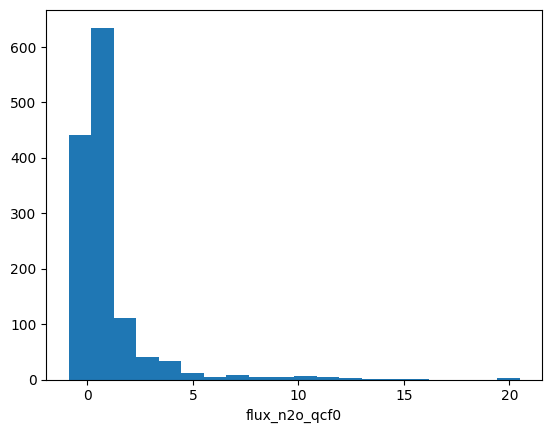

,n_decay_timed,timesince_fert,timesince_soil_preparation,wfps_0.3_roll48hmean,wfps_0.3_diff48h,ts_0.3_roll48hmean,flux_gpp_roll48hsum,flux_n2o_qcf0
timestamp_middle,,,,,,,,
2022-09-01 04:00:00,0.0,30,30,31.006986,-0.231051,19.504965,72.318492,0.242429
2022-09-01 08:00:00,0.0,30,30,30.985383,-0.259238,19.468605,71.271602,-0.020742
2022-09-01 12:00:00,0.0,30,30,30.964550,-0.249998,19.420058,77.264540,-0.233794
2022-09-01 16:00:00,0.0,30,30,30.941929,-0.271450,19.353177,80.504853,-0.255840
2022-09-02 08:00:00,0.0,30,30,30.936376,-0.083852,18.991678,94.061389,-0.265809
...,...,...,...,...,...,...,...,...
2023-10-03 16:00:00,0.0,30,7,53.503897,-0.519952,15.993241,11.711440,1.446062
2023-10-03 20:00:00,0.0,30,7,53.457668,-0.554744,15.991667,12.512343,0.904912
2023-10-04 08:00:00,0.0,30,7,53.330581,-0.505746,16.009387,9.217772,0.781407


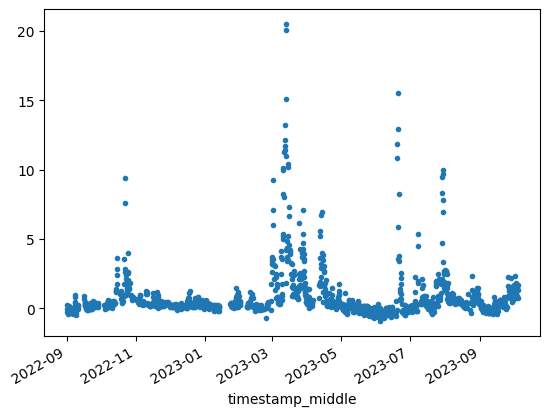

In [9]:
min_value = data[TARGET].min()

def log_transform(x):
    return np.log1p(x - min_value) if min_value < 0 else np.log1p(x)

def inverse_log_transform(x):
    return np.expm1(x) + min_value if min_value < 0 else np.expm1(x)

if LOG_TRANSFORM:
    data[TARGET] = log_transform(data[TARGET])

# Show histogram of TARGET
plt.hist(data[TARGET], bins=20)
plt.xlabel(TARGET)
plt.show()

# Show timeseries
data[TARGET].plot(x_compat=True, style='.');

data

# CROSS-VAL SPLITS

Using stratified approach based on the target variable

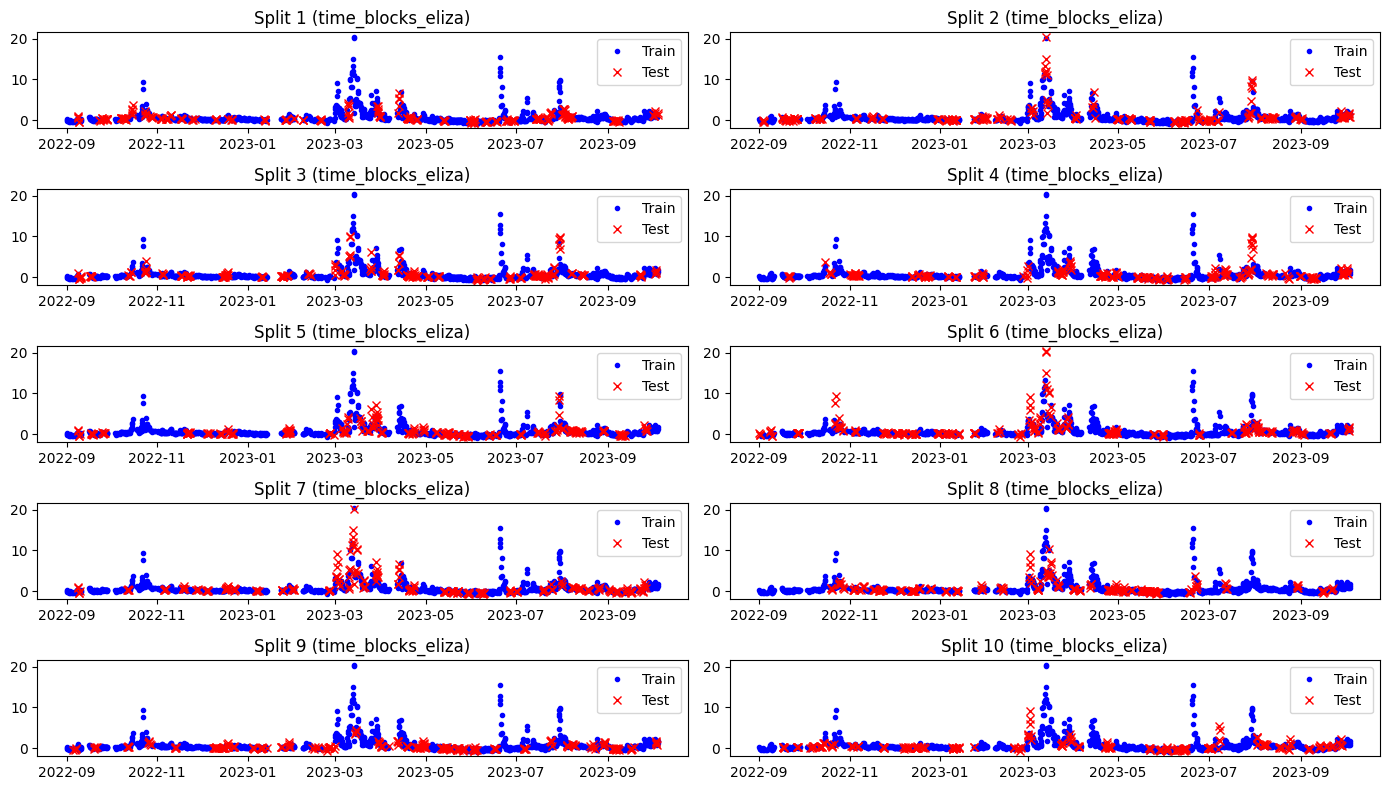

In [10]:
def create_splits(X, y, n_folds, test_size=0.2, random_state=42, n_bins=5):
    """Creates train-test splits using StratifiedShuffleSplit or StratifiedKFold with equal-width binning."""
    
    # Use pd.cut to create equal-width bins (avoids empty bins issue)
    y_binned = pd.cut(y, bins=n_bins, labels=False, include_lowest=True)

    # Select method for stratified splitting
    if CROSSVAL_SPLIT == "shuffle":
        splitter = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=random_state)
    elif CROSSVAL_SPLIT == "kfold":
        splitter = StratifiedKFold(n_splits=n_folds, shuffle=False)

    # Generate train-test splits
    splits = [(train_idx, test_idx) for train_idx, test_idx in splitter.split(X, y_binned)]

    return splits

if CROSSVAL_SPLIT == 'time_blocks_eliza':
    def create_splits(X, y, n_folds, split=0.2, mean_block = 5, min_block=3, random_state=42): # you can set mean block to median_nan_size
        """Generates multiple train-test index splits using block-based cross-validation by varying the random seed."""
        splits = []
        total_test = round(len(X) * split)
        n_blocks = round(total_test/mean_block)

        if mean_block < min_block:
            raise ValueError("Min block size is too large for the number of blocks.")

        for fold in range(n_folds):
            np.random.seed(random_state + fold)  # Change seed for each fold
            
            tt = np.zeros(len(X))  # Array to store train-test assignments

            # Generate random block sizes with normal variation
            blocks = np.array([max(min_block, mean_block + round(v)) 
                            for v in np.random.normal(0, mean_block / 10, n_blocks)])

            # Randomly shuffle the starting positions of test blocks
            available_positions = np.arange(len(X))  # Possible start positions
            np.random.shuffle(available_positions)   # Shuffle them

            # Assign blocks sequentially based on shuffled positions
            assigned = set()
            for b in blocks:
                if len(assigned) >= total_test:
                    break
                # Pick a random starting position
                istart = np.random.choice(available_positions)
                iend = min(istart + int(b), len(X))

                # Ensure blocks don't overlap significantly
                assigned.update(range(istart, iend))
                tt[istart:iend] = 1

            train_idx = np.where(tt == 0)[0]
            test_idx = np.where(tt == 1)[0]
            
            splits.append((train_idx, test_idx))

        return splits


X = data.drop(columns=TARGET)
y = data[TARGET]
# Create the splits using StratifiedShuffleSplit
cross_val_splits = create_splits(X, y, n_folds=N_FOLDS)


# --- PLOT TRAIN-TEST SPLITS ---
n_rows = math.ceil(N_FOLDS / 2)  # Ensure enough rows for all splits
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 8))
axes = axes.flatten()  # Flatten the axes array to make iteration easier

for i, (train_idx, test_idx) in enumerate(cross_val_splits):
    train_idx_mapped = X.iloc[train_idx].index
    test_idx_mapped = X.iloc[test_idx].index

    # Plot train and test points
    axes[i].plot(y.loc[train_idx_mapped].index, y.loc[train_idx_mapped], '.', label='Train', color="blue")
    axes[i].plot(y.loc[test_idx_mapped].index, y.loc[test_idx_mapped], 'x', label='Test', color="red")
    
    axes[i].set_title(f"Split {i + 1} ({CROSSVAL_SPLIT})")
    axes[i].legend()

# Hide unused subplots if n_folds is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# CROSS-VALIDATION

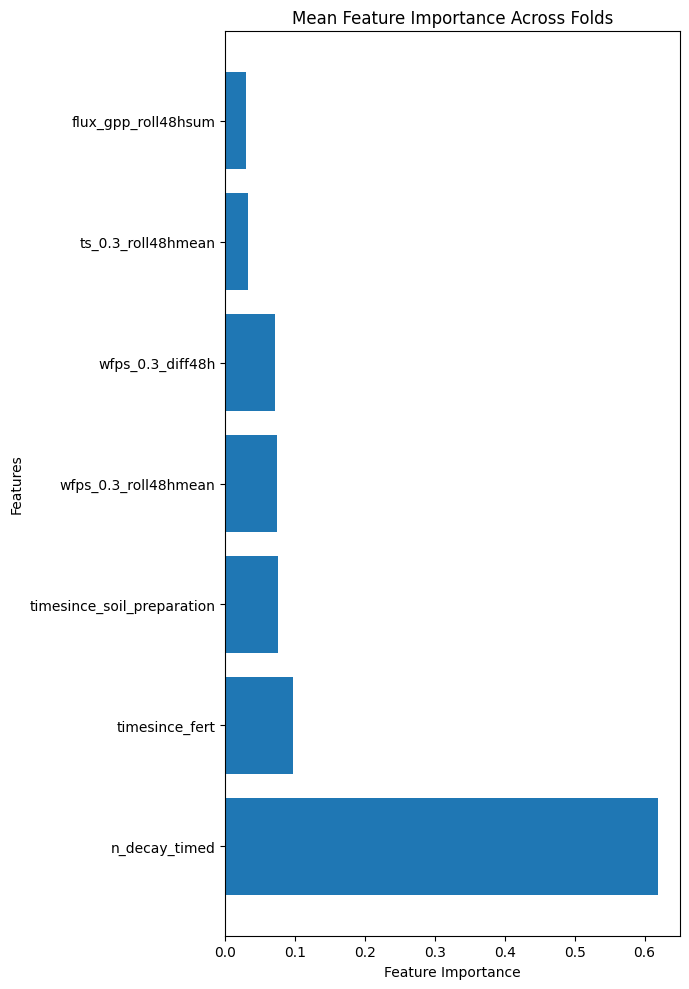

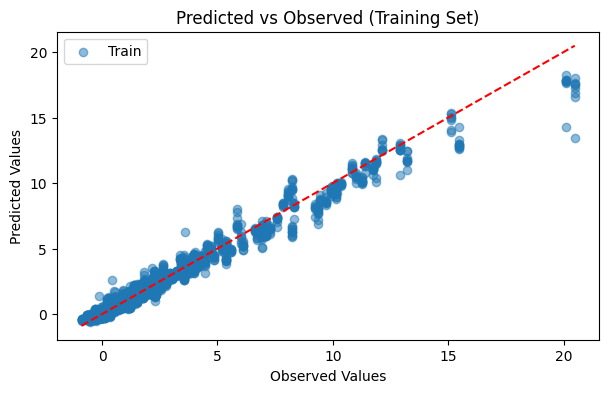

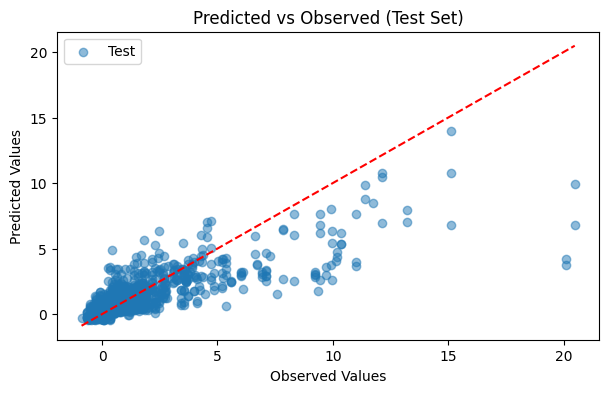

Train RMSE per fold: [0.2866 0.3314 0.2885 0.2955 0.2839 0.2279 0.3354 0.3003 0.2971 0.2961]
Mean Train RMSE: 0.2943
Test RMSE per fold: [0.6781 1.0582 1.0782 1.1518 0.8286 1.8546 1.6858 0.8813 0.5138 0.7741]
Mean Test RMSE: 1.0504
Train R² per fold: [0.9808 0.9636 0.9785 0.9785 0.9805 0.9817 0.9596 0.9779 0.9799 0.9793]
Mean Train R²: 0.9760
Test R² per fold: [0.5927 0.8367 0.6335 0.4147 0.6437 0.5408 0.632  0.6443 0.4939 0.5559]
Mean Test R²: 0.5988


In [11]:
X = data.drop(columns=TARGET)
y = data[TARGET]

# Store results
rmse_train_values, rmse_test_values = [], []
r2_train_values, r2_test_values = [], []
feature_importances_folds = []
y_train_all, y_train_pred_all = [], []
y_test_all, y_pred_test_all = [], []

# Perform cross-validation
for train_idx, test_idx in cross_val_splits:  
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    if LOG_TRANSFORM:
        y_train =  inverse_log_transform(y_train)
        y_test =  inverse_log_transform(y_test)
        y_train_pred =  inverse_log_transform(y_train_pred)
        y_test_pred =  inverse_log_transform(y_test_pred)

    # Store RMSE & R² for training and test sets
    rmse_train_values.append(root_mean_squared_error(y_train, y_train_pred))
    rmse_test_values.append(root_mean_squared_error(y_test, y_test_pred))
    r2_train_values.append(r2_score(y_train, y_train_pred))
    r2_test_values.append(r2_score(y_test, y_test_pred))

    # Store feature importances
    feature_importances_folds.append(model.feature_importances_)

    # Store predictions
    y_train_all.extend(y_train)
    y_train_pred_all.extend(y_train_pred)
    y_test_all.extend(y_test)
    y_pred_test_all.extend(y_test_pred)

# Compute mean feature importance across folds
feature_importances = np.nanmean(feature_importances_folds, axis=0)
# Sort feature importances
order = np.argsort(-feature_importances)  # Sort in descending order
feature_names = X_train.columns[order]  # Get feature names sorted by importance

# Plot sorted feature importances
fig, ax = plt.subplots(figsize=(7, 10))
ax.barh(feature_names, feature_importances[order])
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
ax.set_title("Mean Feature Importance Across Folds")
fig.tight_layout()
plt.show()

# Plot Predicted vs Observed (Training Set)
plt.figure(figsize=(7, 4))
plt.scatter(y_train_all, y_train_pred_all, alpha=0.5, label="Train")
plt.plot([min(y_train_all), max(y_train_all)], [min(y_train_all), max(y_train_all)], color='red', linestyle='--')
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Observed (Training Set)")
plt.legend()
plt.show()

# Plot Predicted vs Observed (Test Set)
plt.figure(figsize=(7, 4))
plt.scatter(y_test_all, y_pred_test_all, alpha=0.5, label="Test")
plt.plot([min(y_test_all), max(y_test_all)], [min(y_test_all), max(y_test_all)], color='red', linestyle='--')
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Observed (Test Set)")
plt.legend()
plt.show()

# Print RMSE and R² for both Training and Test sets
print(f"Train RMSE per fold: {np.array(rmse_train_values).round(4)}")
print(f"Mean Train RMSE: {np.mean(rmse_train_values):.4f}")
print(f"Test RMSE per fold: {np.array(rmse_test_values).round(4)}")
print(f"Mean Test RMSE: {np.mean(rmse_test_values):.4f}")

print(f"Train R² per fold: {np.array(r2_train_values).round(4)}")
print(f"Mean Train R²: {np.mean(r2_train_values):.4f}")
print(f"Test R² per fold: {np.array(r2_test_values).round(4)}")
print(f"Mean Test R²: {np.mean(r2_test_values):.4f}")


# FINAL MODEL

## Split train-test

Block splitting with test blocks that can vary of size and we can define the minimum size

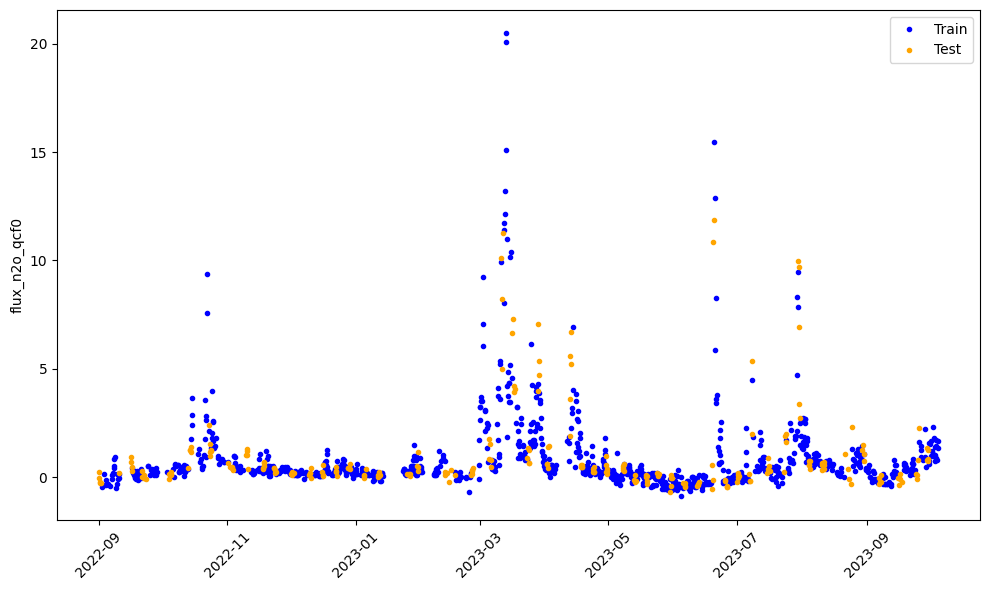

In [12]:
mean_block = 5

def split_blocks(X, y, mean_block = mean_block, split=0.2, min_block=3):
       np.random.seed(42)  # Set seed for reproducibility
       tt = np.zeros(len(X)) # space for training/test assignments
       total_test = round(len(X)* split)
       n_blocks = round(total_test/mean_block)
       if mean_block<min_block:
              print("Error: Min block too long for this many blocks")
              return None
       # Vary the length of blocks around the mean (but not below the min)
       blocks = np.array([mean_block + round(v) for v in np.random.normal(0, mean_block/10, n_blocks)])
       blocks[blocks < min_block] = min_block
       # Assign the blocks
       for n, b in enumerate(blocks):
              istart = round(len(X)/(n_blocks))*(n-1)
              iend = istart+b
              tt[istart:iend] = 1
       X_train = X[tt==0]
       X_test = X[tt==1]
       y_train = y[tt==0]
       y_test = y[tt==1]
       # Return sorted data by index (timestamp)
       return X_train.sort_index(), X_test.sort_index(), y_train.sort_index(), y_test.sort_index(), tt

X = data.drop(columns=TARGET)
y = data[TARGET]
X_train, X_test, y_train, y_test, tt = split_blocks(X, y, mean_block=mean_block) # set number of blocks
              
# Check the split
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted size for better readability
ax.plot(y_train.index, y_train, ".", label="Train", color='blue')
ax.plot(y_test.index, y_test, ".", label="Test", color='orange')
ax.set_ylabel(TARGET)
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()

# Show the plot
plt.show()

## Model training and testing

[0]	validation_0-rmse:2.02644
[1]	validation_0-rmse:1.97276
[2]	validation_0-rmse:1.92123
[3]	validation_0-rmse:1.88556
[4]	validation_0-rmse:1.84785
[5]	validation_0-rmse:1.80556
[6]	validation_0-rmse:1.76209
[7]	validation_0-rmse:1.72792
[8]	validation_0-rmse:1.70251
[9]	validation_0-rmse:1.66944
[10]	validation_0-rmse:1.64259
[11]	validation_0-rmse:1.61119
[12]	validation_0-rmse:1.57765
[13]	validation_0-rmse:1.55890
[14]	validation_0-rmse:1.53125
[15]	validation_0-rmse:1.51123
[16]	validation_0-rmse:1.48762
[17]	validation_0-rmse:1.46167
[18]	validation_0-rmse:1.43483
[19]	validation_0-rmse:1.41966
[20]	validation_0-rmse:1.40475
[21]	validation_0-rmse:1.38584
[22]	validation_0-rmse:1.37296
[23]	validation_0-rmse:1.35328
[24]	validation_0-rmse:1.33583
[25]	validation_0-rmse:1.31697
[26]	validation_0-rmse:1.29816
[27]	validation_0-rmse:1.28771
[28]	validation_0-rmse:1.27819
[29]	validation_0-rmse:1.26417
[30]	validation_0-rmse:1.25888
[31]	validation_0-rmse:1.24687
[32]	validation_0-

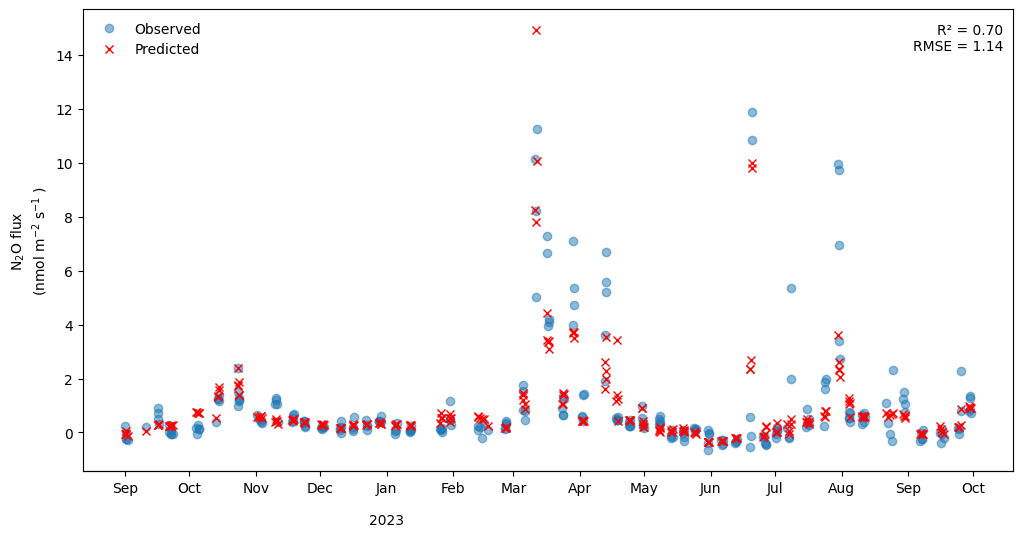

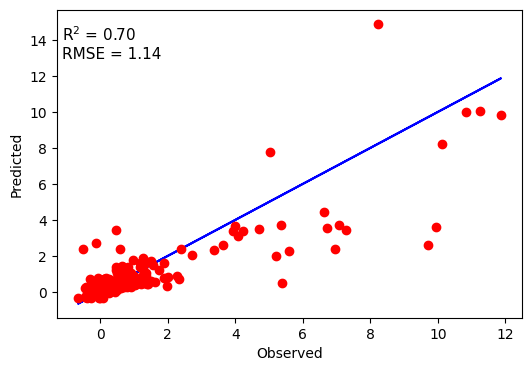

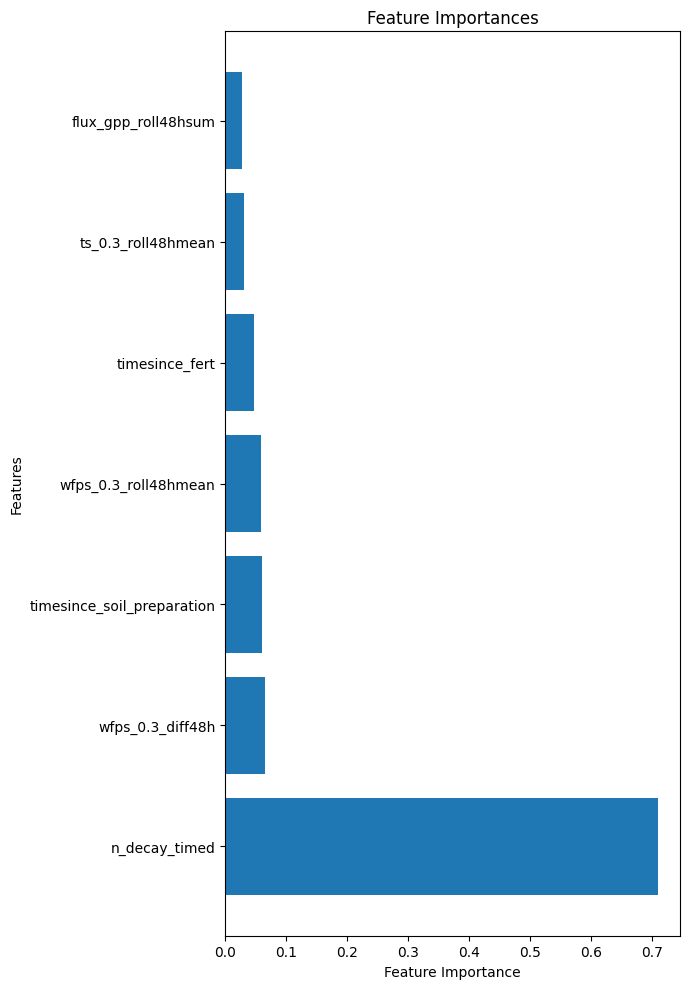

In [13]:
# Use early stopping if using XGBoost
model = RandomForestRegressor(**hyperparams, random_state=42, n_jobs=-1, early_stopping_rounds=10, eval_metric="rmse") if MODEL_TYPE == 'RandomForest' else XGBRegressor(**hyperparams, random_state=42, n_jobs=-1, early_stopping_rounds=10, eval_metric="rmse")

# Predict test set
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Reverse the log transformation on the predictions and the original transformed data when the transformation was used
if LOG_TRANSFORM:
    pred_train = inverse_log_transform(pred_train) 
    pred_test = inverse_log_transform(pred_test)
    y_train = inverse_log_transform(y_train)
    y_test = inverse_log_transform(y_test)

# Calculate R-squared and Mean Squared Error (MSE) for the training set
r2_train = r2_score(y_train, pred_train)
print(f"R-squared (Training set): {r2_train:.4f}")
rmse_train = root_mean_squared_error(y_train, pred_train)
print(f"Root Mean Squared Error (Training set): {rmse_train:.4f}")
# Calculate R-squared and Mean Squared Error (MSE) for the test set
r2_test = r2_score(y_test, pred_test)
print(f"R-squared (Test set): {r2_test:.4f}")
rmse_test = root_mean_squared_error(y_test, pred_test)
print(f"Root Mean Squared Error (Test set): {rmse_test:.4f}")

# Time series plot
fig, ax = plt.subplots(1,figsize=(12, 6))
ax.plot(y_test.index, y_test,"o",label=("Observed"), alpha=0.5)
ax.plot(y_test.index, pred_test,"rx",label=("Predicted"))
# Format x-axis for months
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks for months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as month abbreviation
# Add secondary x-axis for years
secax = ax.secondary_xaxis('bottom')
secax.xaxis.set_major_locator(mdates.YearLocator())  # Year ticks
secax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
secax.tick_params(axis='x', length=0, pad=30)  # Add padding for better readability
# Add R2 and RMSE text
ax.text(0.99, 0.97, f'R² = {r2_test:.2f}\nRMSE = {rmse_test:.2f}',
        transform=ax.transAxes, va='top', ha='right')
ax.set_ylabel('N$_2$O flux\n(nmol m$^{-2}$ s$^{-1}$ )')
ax.legend(frameon=False, loc="upper left")
# save fig
plt.savefig('./figs/final/model_performance.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Obs Vs predicted
fig, ax = plt.subplots(1,figsize=(6,4))
ax.plot(y_test,y_test,"b-")
ax.plot(y_test,pred_test,"ro")
# Add R2 and RMSE text
ax.text(0.01, 0.95, f'R$^{2}$ = {r2_test:.2f}\nRMSE = {rmse_test:.2f}',
        transform=ax.transAxes, va='top', fontsize=11)
ax.set_xlabel("Observed")
ax.set_ylabel("Predicted")
plt.show()

# Plot feature importances
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]  # Sort descending
feature_names_sorted = X_train.columns[sorted_idx]

fig, ax = plt.subplots(figsize=(7, 10))
ax.barh(feature_names_sorted, importances[sorted_idx])
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
ax.set_title("Feature Importances")
plt.tight_layout()
plt.show()

# ALE PLOTS

- ALE (Accumulated Local Effects) plots show how a feature influences model predictions while accounting for feature dependencies.
- Unlike Partial Dependence Plots (PDP) and SHAP, ALE handles correlated features correctly.
- ALE computes local changes in predictions and accumulates them over the feature range.
- The plots are centered around zero, making interpretation straightforward (positive = increase, negative = decrease).

PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


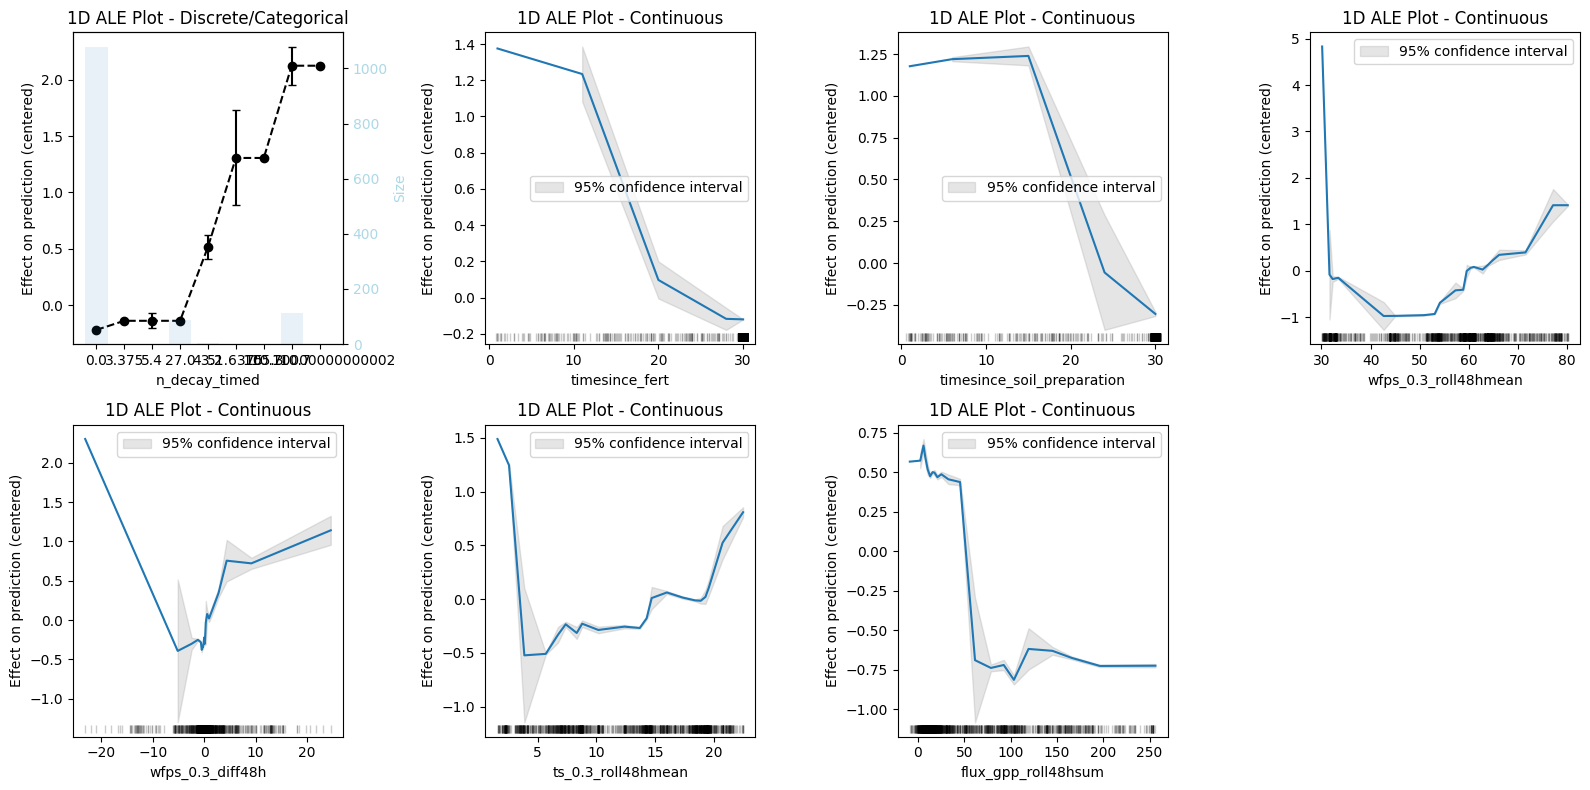

In [14]:
# Define the number of rows and columns for the grid
num_features = len(selected_features)
cols = 4  # Set the number of columns in the grid
rows = -(-num_features // cols)  # Ceiling division to get rows

# Create figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()  # Flatten for easy iteration

# Generate ALE plots
for i, col in enumerate(selected_features):
    ale(
        X=X.dropna(), 
        model=model, 
        feature=[col],  # Feature should be passed as a string, not a list
        grid_size=20, 
        include_CI=True,
        fig=fig,  # Pass the figure explicitly
        ax=axes[i],  # Assign the subplot
    )

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust spacing
plt.show()